# `sklearn` Plotting Helpers

The file `plotting_helpers.py` contains two helper functions.  The goal is to emulate the ease-of-use of Scikit-learn's `metrics.plot_confusion_matrix` ([link to docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html)) and `metrics.plot_roc_curve` ([link to docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html))

The source code is heavily borrowed from [Scikit-learn's source code](https://github.com/scikit-learn/scikit-learn/), with some simplifications and other small changes to the interface.

Specific use cases for using these helpers rather than the Scikit-learn ones:

1. You need to use a version of Scikit-learn that is older than 0.22, when these functions were introduced
2. You are using the Keras Scikit-learn API ([link to docs](https://keras.io/scikit-learn-api/)), which is not compatible with these functions

This notebook will demonstrate using them with both Scikit-learn and Keras models

## Load Data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
tf.logging.set_verbosity(tf.logging.ERROR)

import plotting_helpers

In [2]:
data = load_breast_cancer()

In [3]:
X = pd.DataFrame(data["data"], columns=data["feature_names"])
y = pd.Series(data["target"])

In [4]:
y.value_counts()

1    357
0    212
dtype: int64

## Preprocess Data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
X_train.shape

(426, 30)

In [7]:
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
287,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,...,13.62,15.54,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915
512,13.40,20.52,88.64,556.7,0.11060,0.14690,0.14450,0.08172,0.2116,0.07325,...,16.41,29.66,113.30,844.4,0.15740,0.3856,0.5106,0.20510,0.3585,0.11090
402,12.96,18.29,84.18,525.2,0.07351,0.07899,0.04057,0.01883,0.1874,0.05899,...,14.13,24.61,96.31,621.9,0.09329,0.2318,0.1604,0.06608,0.3207,0.07247
446,17.75,28.03,117.30,981.6,0.09997,0.13140,0.16980,0.08293,0.1713,0.05916,...,21.53,38.54,145.40,1437.0,0.14010,0.3762,0.6399,0.19700,0.2972,0.09075
210,20.58,22.14,134.70,1290.0,0.09090,0.13480,0.16400,0.09561,0.1765,0.05024,...,23.24,27.84,158.30,1656.0,0.11780,0.2920,0.3861,0.19200,0.2909,0.05865


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build Models

In [9]:
dummy_model = DummyClassifier(strategy="most_frequent")
rfc = RandomForestClassifier(random_state=42, n_estimators=5, max_depth=10)

In [10]:
def create_nn_model():
    model = Sequential()
    model.add(Dense(10, activation='relu', input_shape=(30,)))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy']) 
    return model

nn = KerasClassifier(create_nn_model, epochs=10, batch_size=50, verbose=0)

## Fit Models on Training Data

In [11]:
dummy_model.fit(X_train, y_train)
rfc.fit(X_train, y_train)
nn.fit(X_train_scaled, y_train)

## Show Model Performance on Training Data

### Train ROC curves

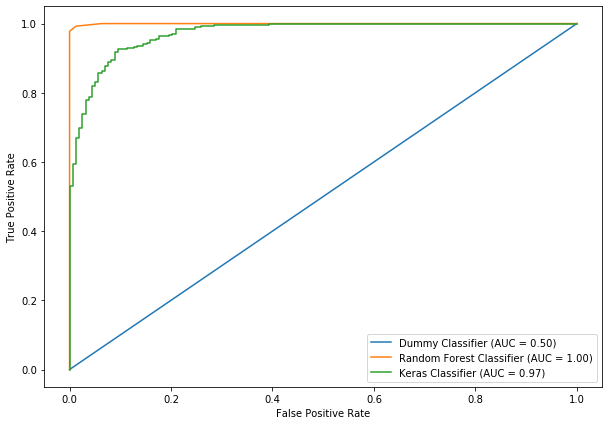

In [12]:
fig, ax = plt.subplots(figsize=(10, 7))

plotting_helpers.plot_roc_curve_custom(dummy_model, X_train, y_train, "Dummy Classifier", ax)
plotting_helpers.plot_roc_curve_custom(rfc, X_train, y_train, "Random Forest Classifier", ax)
plotting_helpers.plot_roc_curve_custom(nn, X_train_scaled, y_train, "Keras Classifier", ax)

### Train Confusion Matrices

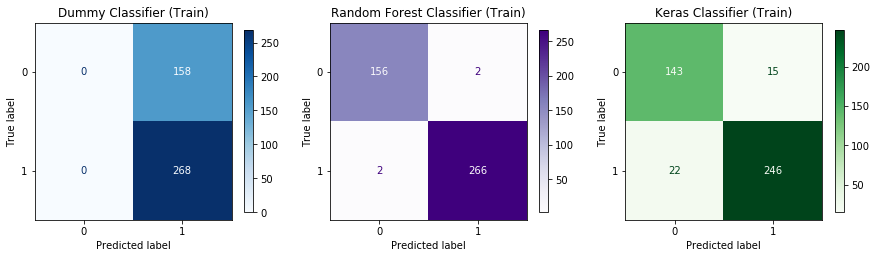

In [13]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=3)

plotting_helpers.plot_confusion_matrix_custom(
    dummy_model, X_train, y_train, 
    "Dummy Classifier (Train)", axes[0], cmap="Blues")
plotting_helpers.plot_confusion_matrix_custom(
    rfc, X_train, y_train, 
    "Random Forest Classifier (Train)", axes[1], cmap="Purples")
plotting_helpers.plot_confusion_matrix_custom(
    nn, X_train_scaled, y_train, 
    "Keras Classifier (Train)", axes[2], cmap="Greens")

## Show Model Performance on Test Data

(Obviously this is skipping to the end of a modeling process)

### Test ROC Curves

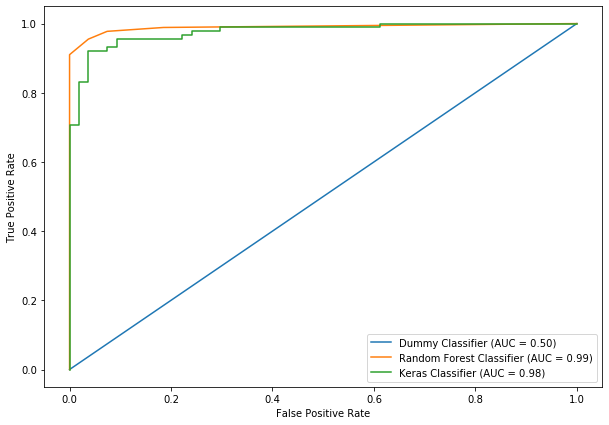

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))

plotting_helpers.plot_roc_curve_custom(dummy_model, X_test, y_test, "Dummy Classifier", ax)
plotting_helpers.plot_roc_curve_custom(rfc, X_test, y_test, "Random Forest Classifier", ax)
plotting_helpers.plot_roc_curve_custom(nn, X_test_scaled, y_test, "Keras Classifier", ax)

### Test Confusion Matrics

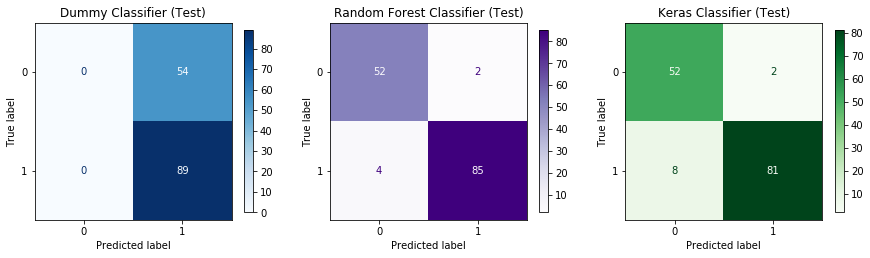

In [15]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=3)

plotting_helpers.plot_confusion_matrix_custom(
    dummy_model, X_test, y_test, 
    "Dummy Classifier (Test)", axes[0], cmap="Blues")
plotting_helpers.plot_confusion_matrix_custom(
    rfc, X_test, y_test, 
    "Random Forest Classifier (Test)", axes[1], cmap="Purples")
plotting_helpers.plot_confusion_matrix_custom(
    nn, X_test_scaled, y_test, 
    "Keras Classifier (Test)", axes[2], cmap="Greens")